## Second Generation : Strategic Trade Models

전략적 거래 모델은 비유동성(illiquidity)의 이해와 측정에 집중한다. 비유동성은 프리미엄과 연관된 리스크이므로, 금융 모델링에 있어 중요한 정보성 특성이다. 이 모델은 거래를 정보 기반 거래자와 정보가 없는 거래자 사이의 사이의 전략적 상호작용으로 설명한다는 점에서 강력한 이론적 기반을 가지며, 이를 통해 거래량의 부호화 주문 흐름의 불균형에 주목한다. 이런 대부분의 측성은 회귀를 통해 추정된다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_parquet('../../Data/AAPL_tick.parquet')

### Kyle's Lambda

Kyle은 다음과 같은 전략적 거래 모델을 도입했다. 최종 가치가 $v ~\sim~ N(p_0, \Sigma_0)$인 위험성 자산과 다음 두 거래자를 고려해 본다
1. $v$와 독립적으로 $u = N(0, \sigma_u^2)$ 만큼의 수량을 거래하는 잡음 거래자
2. $v$를 알고 시장가 주문을 통해 수량 $x$를 원하는 정보 기반 거래자

시장 조성자들은 전체 주문 흐름 $y = x+u$를 관찰하고, 그에 해당하는 가격 $p$를 설정한다. 이 모형에서 시장 조성자들은 잡음 영역에 해당하는 거래자들의 주문과 정보 기반 거래자의 주문을 구분하지 못한다. 이들은 가격을 정보 기반 거래자의 존재를 나타낼 수 있는 주문 흐름 불균형의 함수로 조정한다. 그러므로 가격 변화와 주문 흐름의 불균형 사이에는 양의 관계가 있고, 이를 market impact라고 부른다.

#### 정보 기반 거래자들의 추측

**정보 기반 거래자들**은 시장 조성자들이 선형 가격 조정 함수 $p = \lambda y+u$를 사용한다고 추정한다. 여기서 $\lambda$는 유동성 척도의 역수이다(즉 $\lambda$값이 높을수록 비유동적이다). 이 때, 정보기반 거래자들의 이윤 함수는 다음과 같다
$$\pi = (v - p)x$$

이윤함수의 Second Order Condition은 다음과 같다

$$\lambda > 0, ~~~ x = \frac{v-\mu}{2\lambda}$$

#### 시장 조성자들의 추측

**시장 조성자들**은 정보 기반 거래자들의 소유가 $v$의 선형함수, 즉 $x = \alpha + \beta v$라고 추측하는데, 이는 다음을 의미한다.

$$\alpha = -\frac{\mu}{2\lambda}, ~~ \beta = \frac{1}{2\lambda}$$

더 낮은 유동성은 더 높은 $\lambda$값을 의미한다. 이는 정보 기반 거래자들이 거래를 더욱 기피한다는 것을 의미한다

#### Kyle's Lambda

Kyle은 시장 조성자가 수익 극대화와 시장 효율 사이의 균형을 반드시 찾아야 한다고 주장한다. 따라서 앞의 선형 함수하에서 유일한 해는 다음과 같을 때 발생한다

$$\mu = p_0$$
$$\alpha = p_0\sqrt{\frac{\sigma_u^2}{\Sigma_0}}$$
$$\lambda = \frac{1}{2} \sqrt{\frac{\Sigma_0}{\sigma_u^2}}$$
$$\beta = \sqrt{\frac{\sigma_u^2}{\Sigma_0}}$$

정보 기반 거래자의 기대 수익(Expected Return)은 다음과 같이 다시 쓸 수 있다

$$E[\pi] = \frac{(v-p_0)^2}{2}\sqrt{\frac{\sigma_u^2}{\Sigma_0}} = \frac{1}{4\lambda}(v-p_0)^2$$

이는 정보 기반 거래자는 세 가지 종류의 수익 원천이 있다는 것을 암시한다

1. 자산의 가격 오류
2. 잡음 투자가의 순주문 흐름 분산. 즉, 잡음 투자가들(개미)이 많을수록 정보 기반 거래자들이 자신의 의도를 감추기가 쉬워진다
3. 최종 증권 분산의 역수, 변동성이 낮을수록 가격 오류로부터의 수익을 얻기 쉬워진다

카일의 모형에서 변수 $\lambda$는 가격 충격을 포착한다. 비유동성은 $v$의 불확실성과 함께 증가하고, 잡음의 양에 따라 감소한다. $\lambda$는 하나의 측성으로 다음과 같은 회귀를 적합화하여 구할 수 있다

$$\Delta p_t = \lambda(b_t V_t) + \epsilon_t$$

여기서 $\{p_t\}$는 가격 시계열, $\{b_t\}$는 공격적 거래자 플래그의 시계열, $\{V_t\}$는 거래량 시계열이므로 $\{b_tV_t\}$는 거래량의 부호 또는 순주문 흐름의 시계열이 된다.

In [3]:
data_ohlc = data['Price'].resample('1T').ohlc()
data_ohlc['volume'] = data['Volume'].resample('1T').sum()

In [4]:
from FinancialMachineLearning.features.microstructure import *

kyle = bar_based_kyle_lambda(close = data_ohlc['close'], volume = data_ohlc['volume'])

In [5]:
kyle.dropna().head()

2023-04-03 09:50:00    0.000014
2023-04-03 09:51:00    0.000014
2023-04-03 09:52:00    0.000012
2023-04-03 09:53:00    0.000011
2023-04-03 09:54:00    0.000011
dtype: float64

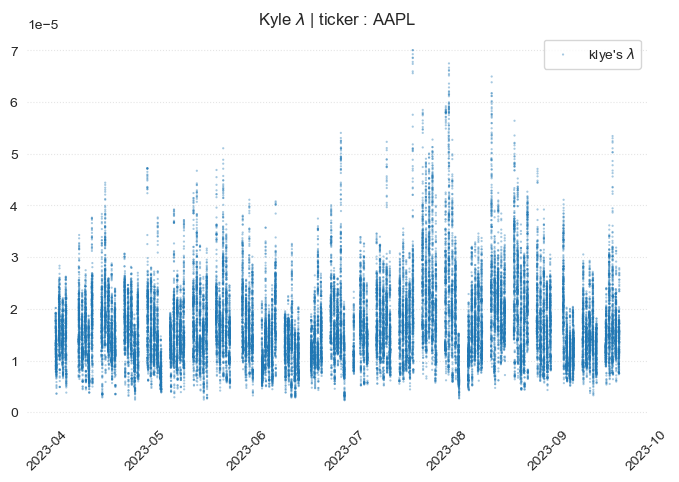

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    kyle.index, 
    kyle,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = r"klye's $\lambda$"
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Kyle $\lambda$ | ticker : AAPL')
plt.show()

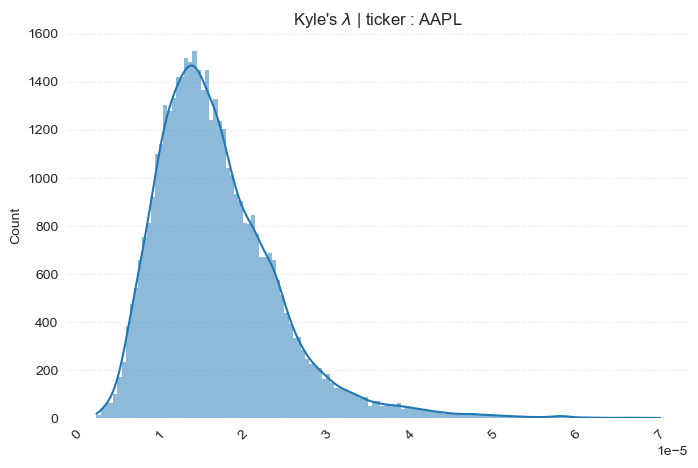

In [12]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(kyle, ax = ax, edgecolor = 'none', kde = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r"Kyle's $\lambda$ | ticker : AAPL")
plt.show()

#### Amihud's Lambda

Amihud(2002)는 절대 수익률과 비유동성 사이의 양의 관계를 연구했다. 그는 거래량의 1달러에 연관된 일별 가격 반응을 계산한 값이 가격 충격의 대리 척도라고 주장했다. 이 아이디어를 구현하는 방법 중 하나는 다음과 같다

$$|\Delta \log [\tilde p_\tau]| = \lambda \sum_{t \in B_tau}(p_tV_t) + \epsilon_\tau$$

여기서 $B_\tau$는 바 $\tau$에 포함된 거래 집합이고, $\tilde p_\tau$는 바 $\tau$의 종가이다. 또한, $p_tV_t$는 거래 $t \in B_\tau$에 관여된 달러 거래량이다.

In [15]:
dollar_vol = (data['Price'] * data['Volume']).resample('1T').sum()

In [16]:
amihud = bar_based_amihud_lambda(
    close = data_ohlc['close'],
    dollar_volume = dollar_vol
)

In [17]:
amihud.dropna().head()

2023-04-03 09:50:00    5.061049e-10
2023-04-03 09:51:00    5.060709e-10
2023-04-03 09:52:00    4.527122e-10
2023-04-03 09:53:00    4.039226e-10
2023-04-03 09:54:00    4.107180e-10
dtype: float64

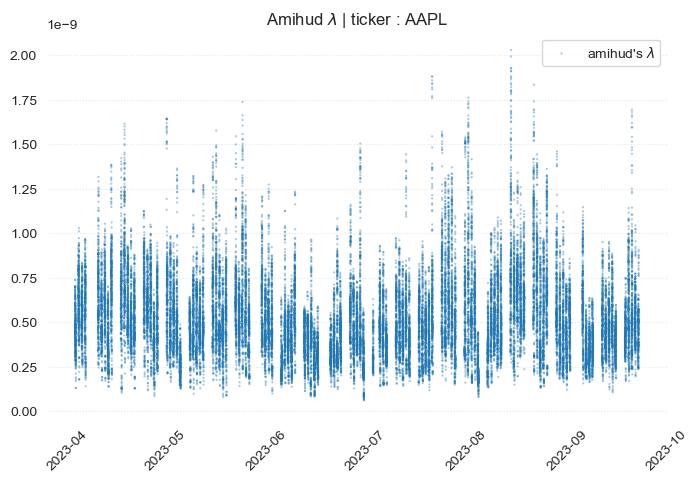

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    amihud.index, 
    amihud,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = r"amihud's $\lambda$"
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Amihud $\lambda$ | ticker : AAPL')
plt.show()

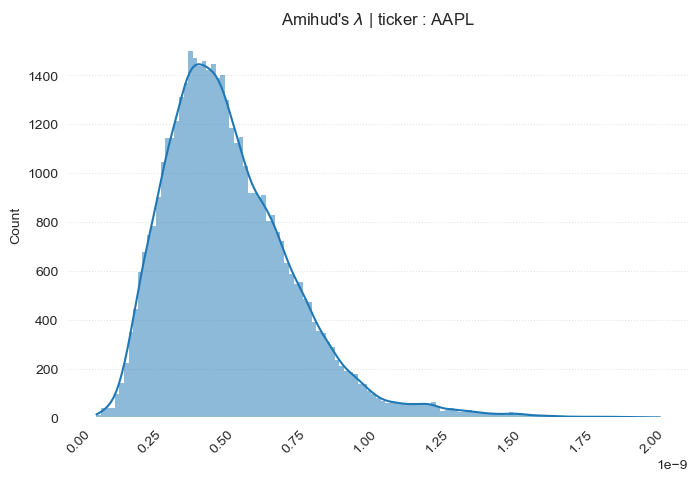

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(amihud, ax = ax, edgecolor = 'none', kde = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r"Amihud's $\lambda$ | ticker : AAPL")
plt.show()

#### Hasbrouk's Lambda

Hasbrouk은 Kyle과 Amihud의 아이디어를 따랐고, 이들은 일중 거래와 호가 데이터(Trade and Quote)에 기반을 둔 가격 충격 계수를 계산하는데 적용했다. Hasbrouk은 Gibbs sampler를 사용해 아래 회귀식의 Bayes 추정을 수행하였다

$$\log[\tilde p_{i,\tau}] - \log[\tilde p_{i,\tau-1}] = \lambda_i \sum_{t \in B_{i,\tau}}\Big( b_{i,t} \sqrt{p_{i,t}V_{i,t}}\Big) + \epsilon_{i,\tau}$$

$B_{i,\tau}$는 증권 $i$에 대한 바 $\tau$에 속한 거래 집합이다. 여기서 $i = 1,\cdots,I$이고, $\tilde p_{i,\tau}$는 증권 $i$의 바 $\tau$의 종가이며, $b_{i,t} \in \{-1, 1\}$은 거래 $t \in B_{i,\tau}$ 매수자 개시인지 매도자 개시인지 알려 준다. $p_{i,t}V_{i,t}$는 거래 $t \in B_{i,\tau}$에 관련된 달러 거래량이다. 다음 모든 증권 $i$에 대해 $\lambda_i$를 계산하고 이를 거래의 유효 비용을 근사하는 특성으로 사용한다

In [20]:
hasbrouck = bar_based_hasbrouck_lambda(
    close = data_ohlc['close'],
    dollar_volume = dollar_vol
)

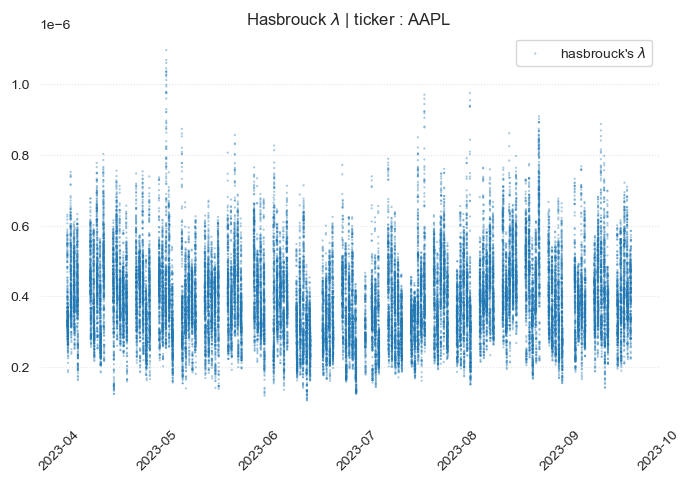

In [21]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    hasbrouck.index, 
    hasbrouck,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = r"hasbrouck's $\lambda$"
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Hasbrouck $\lambda$ | ticker : AAPL')
plt.show()

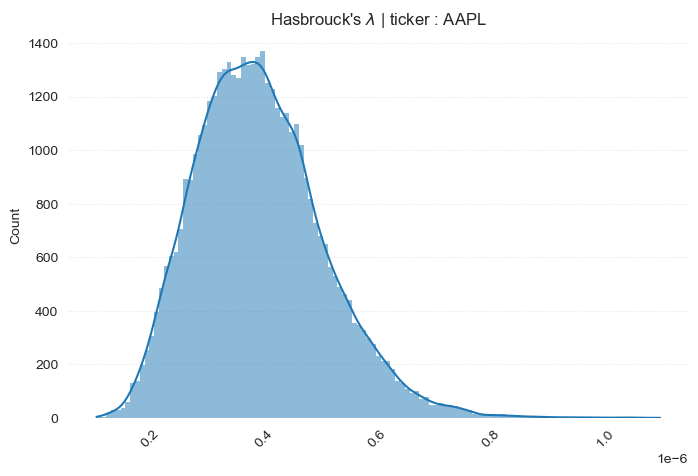

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(hasbrouck, ax = ax, edgecolor = 'none', kde = True)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r"Hasbrouck's $\lambda$ | ticker : AAPL")
plt.show()